Source of inspiration for this model: https://www.kaggle.com/code/imsparsh/gtzan-genre-classification-deep-learning-val-92-4/notebook

In [11]:
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import matplotlib as plt
import librosa
import os
import subprocess
import csv
from sklearn import metrics, model_selection, preprocessing

Define paths for this model

In [12]:
absolute_path = "f:\\AI Projects\\Music Classification"
relative_path = "Data\\GTZAN\\genres"
full_path = os.path.join(absolute_path, relative_path)
print(full_path)

f:\AI Projects\Music Classification\Data\GTZAN\genres


List all music genres contained in this dataset

In [13]:
generes_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

In [14]:
len(generes_list)

10

Read in the metadata

In [15]:
GTZAN_path = os.path.join(absolute_path,"Data\\GTZAN\genres")
file_path = os.path.join(GTZAN_path,"metadata.csv")
metadata = pd.read_csv(file_path)
metadata.head()

,filename,length,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,30.0,0.349951,0.130192,1784.416546,2002.657106,3806.418650,0.083066,123.046875,-113.619385,...,8.806787,-3.665802,5.745939,-5.161711,0.750298,-1.688358,-0.409329,-2.298869,1.219947,blues
1,blues.00001.wav,30.0,0.340945,0.095892,1529.871314,2038.612143,3548.986873,0.056044,107.666016,-207.581512,...,5.375942,-2.237833,4.217125,-6.011047,0.932668,-0.717028,0.292333,-0.285717,0.532144,blues
2,blues.00002.wav,30.0,0.363562,0.175494,1552.637786,1747.382028,3041.089944,0.076301,161.499023,-90.776344,...,5.785763,-8.899733,-1.087024,-9.216774,2.453648,-7.721793,-1.816497,-3.434354,-2.231391,blues
3,blues.00003.wav,30.0,0.404848,0.141139,1070.110059,1596.244204,2185.061787,0.033309,172.265625,-199.462006,...,6.085354,-2.476188,-1.076225,-2.876056,0.776909,-3.320055,0.637263,-0.617507,-3.406940,blues
4,blues.00004.wav,30.0,0.308598,0.091540,1835.507009,1748.367477,3581.003346,0.101500,135.999178,-160.291855,...,-2.809849,-6.935621,-7.559294,-9.172152,-4.510408,-5.453736,-0.924468,-4.408076,-11.701833,blues


Use all 100 samples for training data

Hand picked songs for test data
E.g Livin on a prayer
Don't stop believin
Master of puppets
Smells like teens spirit
As it was
All too well
Beethoven symphony 9


In [16]:
print(list(metadata.columns[metadata.isnull().any()]))

[]


No NA or null values in the metadata

Add labels to each file 

In [17]:
label_index = dict()
index_label = dict()

for i, x in enumerate(metadata.label.unique()):
    label_index[x] = i
    index_label[i] = x

metadata.label = [label_index[l] for l in metadata.label]
metadata.head()

,filename,length,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,30.0,0.349951,0.130192,1784.416546,2002.657106,3806.418650,0.083066,123.046875,-113.619385,...,8.806787,-3.665802,5.745939,-5.161711,0.750298,-1.688358,-0.409329,-2.298869,1.219947,0
1,blues.00001.wav,30.0,0.340945,0.095892,1529.871314,2038.612143,3548.986873,0.056044,107.666016,-207.581512,...,5.375942,-2.237833,4.217125,-6.011047,0.932668,-0.717028,0.292333,-0.285717,0.532144,0
2,blues.00002.wav,30.0,0.363562,0.175494,1552.637786,1747.382028,3041.089944,0.076301,161.499023,-90.776344,...,5.785763,-8.899733,-1.087024,-9.216774,2.453648,-7.721793,-1.816497,-3.434354,-2.231391,0
3,blues.00003.wav,30.0,0.404848,0.141139,1070.110059,1596.244204,2185.061787,0.033309,172.265625,-199.462006,...,6.085354,-2.476188,-1.076225,-2.876056,0.776909,-3.320055,0.637263,-0.617507,-3.406940,0
4,blues.00004.wav,30.0,0.308598,0.091540,1835.507009,1748.367477,3581.003346,0.101500,135.999178,-160.291855,...,-2.809849,-6.935621,-7.559294,-9.172152,-4.510408,-5.453736,-0.924468,-4.408076,-11.701833,0


Shuffle the dataset

In [18]:
seed = 12
np.random.seed(seed)
df_shuffle = metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
df_shuffle.drop(['filename','length'],axis=1,inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

In [19]:
X_train, df_test_valid_X, y_train, df_test_valid_y = model_selection.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)

X_dev, X_test, y_dev, y_test = model_selection.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

Scale the features

In [20]:
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [21]:
dropout_rate = 0.2

model = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(10, activation='softmax'),
])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              28672     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [22]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [23]:
history = model.fit(X_train,y_train,validation_data=(X_dev,y_dev),epochs=500,batch_size=128)

Epoch 1/500
6/6 [==============================] - 7s 85ms/step - loss: 2.1275 - accuracy: 0.2086 - val_loss: 1.7590 - val_accuracy: 0.3535
Epoch 2/500
6/6 [==============================] - 0s 14ms/step - loss: 1.8144 - accuracy: 0.3429 - val_loss: 1.5799 - val_accuracy: 0.4242
Epoch 3/500
6/6 [==============================] - 0s 14ms/step - loss: 1.6073 - accuracy: 0.4329 - val_loss: 1.3590 - val_accuracy: 0.5051
Epoch 4/500
6/6 [==============================] - 0s 14ms/step - loss: 1.5248 - accuracy: 0.4614 - val_loss: 1.3021 - val_accuracy: 0.5101
Epoch 5/500
6/6 [==============================] - 0s 14ms/step - loss: 1.4234 - accuracy: 0.4900 - val_loss: 1.2109 - val_accuracy: 0.5909
Epoch 6/500
6/6 [==============================] - 0s 12ms/step - loss: 1.3429 - accuracy: 0.5314 - val_loss: 1.2532 - val_accuracy: 0.5556
Epoch 7/500
6/6 [==============================] - 0s 11ms/step - loss: 1.2983 - accuracy: 0.5157 - val_loss: 1.1222 - val_accuracy: 0.6212
Epoch 8/500
6/6 [===

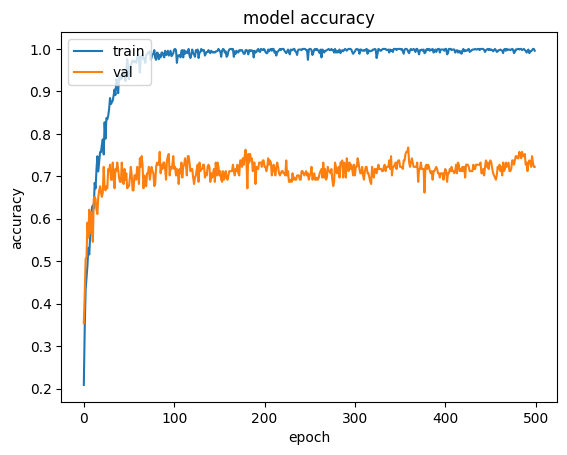

In [24]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

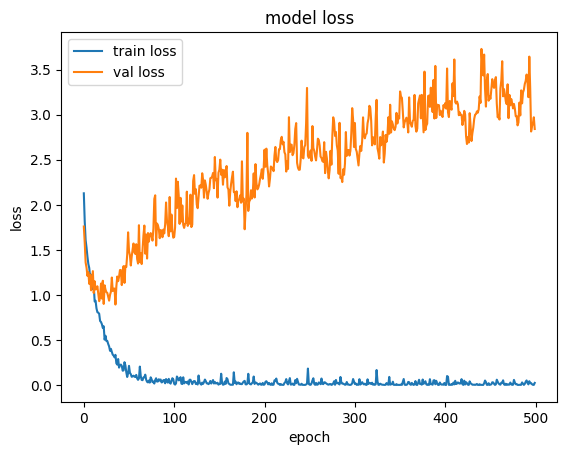

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','val loss'], loc='upper left')
plt.show()

In [26]:
loss, accuracy = model.evaluate(X_test,y_test,batch_size=128)

print(f"Loss: {round(loss,4)}")
print(f"Accuracy: {round(accuracy * 100,2)}%")

1/1 [==============================] - 0s 23ms/step - loss: 4.5569 - accuracy: 0.6863
Loss: 4.5569
Accuracy: 68.63%


Accuracy currently sitting at 68%